In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests


from pinkrigs_tools.dataset.query import load_data
from utils import format_session
from classes import session_data, exp_data

# Load & Format Data

In [2]:
# runs only when pandas==1.3.5 - run !pip install pandas==1.3.5
recordings = load_data(subject = 'AV043',
                       expDate = '2024-03-14:2024-03-20', # 2024-03-14 or 2024-03-20 
                       expDef = 'multiSpaceWorld_checker_training',
                       data_name_dict= 'all-default')


formatted_events, formatted_cluster_data, spikes, dominant_modality, session_no, session_date = format_session(recordings, 
                                                                                                 session_no = 1, 
                                                                                                 expDef = 'multiSpaceWorld_checker_training', 
                                                                                                 check_dominantModality=True)

/Users/Serkan/opt/anaconda3/envs/pink_rigs/lib/python3.10/site-packages/floras_helpers/hist/regions.py:430: RuntimeWarning: invalid value encountered in cast
  level=df_regions.depth.to_numpy().astype(np.uint16),
/Users/Serkan/opt/anaconda3/envs/pink_rigs/lib/python3.10/site-packages/floras_helpers/hist/regions.py:432: RuntimeWarning: invalid value encountered in cast
  order=df_regions.graph_order.to_numpy().astype(np.uint16))
/Users/Serkan/Desktop/academia/PhD/rotations/cortex_lab/project/pinkrigs_tools/utils/spk_utils.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusInfo.brainLocationAcronyms_ccf_2017[


# Creating Objects

In [ ]:
data = exp_data()
for i in range(len(recordings)):
    data.add_session(session_data(*format_session(recordings, 
                                                 session_no = i, 
                                                 expDef = 'multiSpaceWorld_checker_training', 
                                                 check_dominantModality=True)),
                     baseline_start = -0.5, stimulus_end = 0.5, bin_size = 0.01)

/Users/Serkan/Desktop/academia/PhD/rotations/cortex_lab/project/classes.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['vis_loc'] = np.select(vis_conditions, vis_choices, default='o')
/Users/Serkan/Desktop/academia/PhD/rotations/cortex_lab/project/classes.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['aud_loc'] = np.select(aud_conditions, aud_choices, default='c')


# Simple Visualisation

## PSTH of a session

### All stimuli

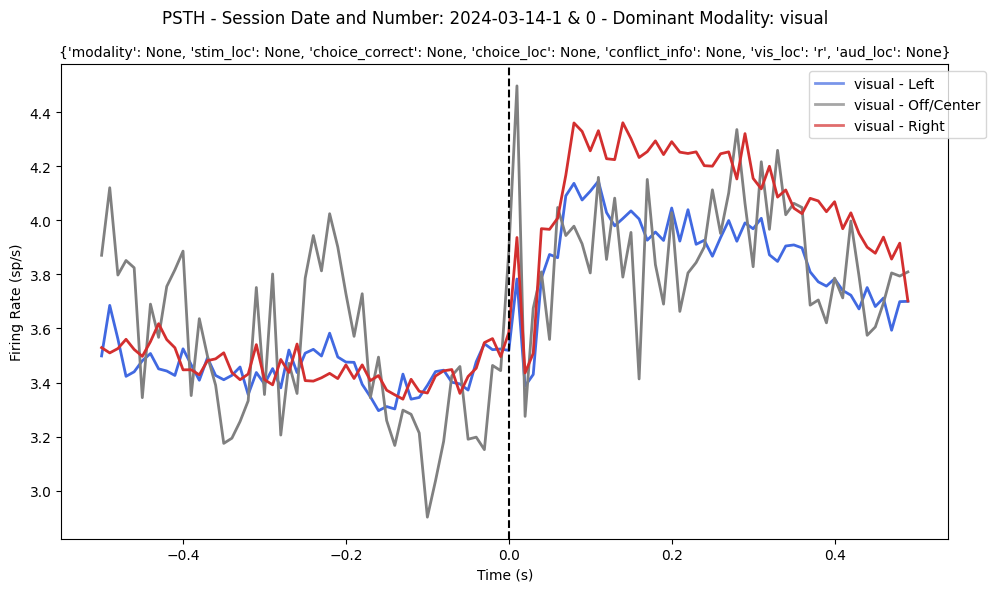

In [ ]:
obj = data.session_data_obj[0]
obj.return_mask()
obj.plot_psth() # mean firing rate of neuron X over all trials

### Per stimulus

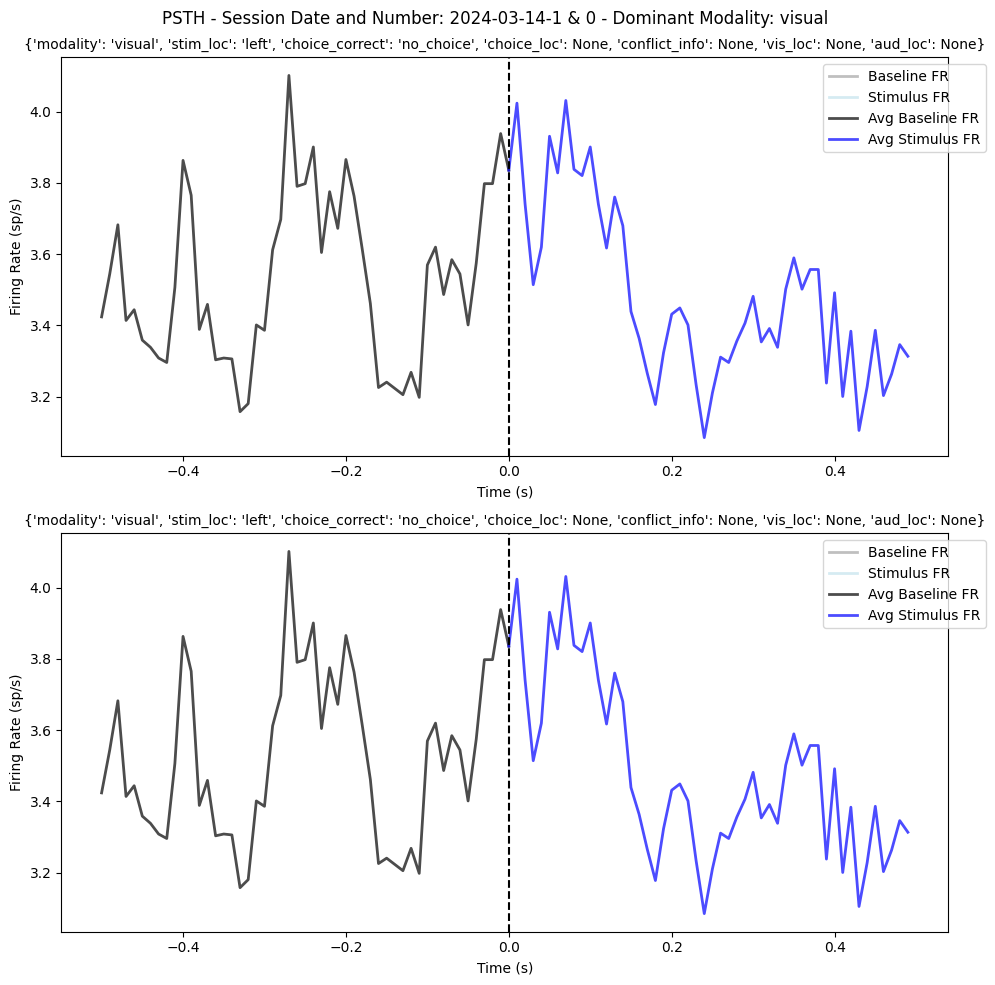

In [ ]:
obj.return_mask(stim_loc= 'left', modality = 'visual', choice_correct= 'no_choice')

obj.plot_psth(figsize = (10, 10),
              xlim = (None, None),
              ylim = (None, None),
              filter_info = [{'modality': 'visual',
                             'stim_loc': 'left',
                             'choice_correct': 'c',
                             'choice_loc': None,
                             'conflict_info': None
                             },
                             {'modality': 'conflict',
                             'stim_loc': 'left',
                             'choice_correct': 'c',
                             'choice_loc': None,
                             'conflict_info': None
                             },
                             ],
              color_based_on = None,
              only_average = True
              ) # mean firing rate of neuron X over all trials


## Raster Plot of a neuron across trials

### All stimuli

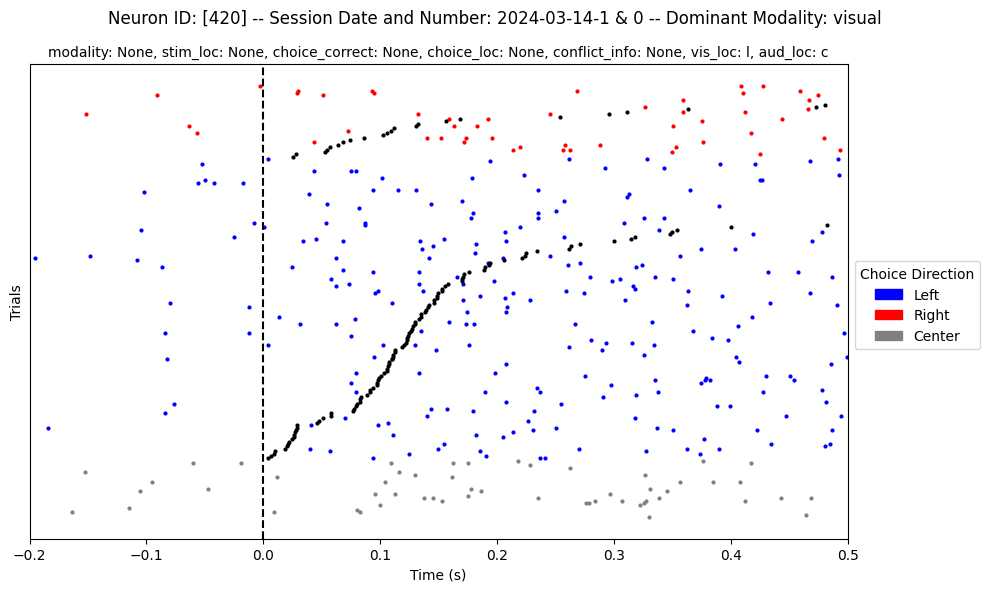

In [6]:
obj.return_mask(vis_loc = 'l', aud_loc = 'c')
obj.plot_spike_raster(neuron_ids = [420], first_move = False,
                      sort_choice_loc = True, sort_response_time = True)

/var/folders/l1/l742y54d4hx05wj38054vs_r0000gn/T/ipykernel_17482/3424427679.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 0, 1, 0.95])


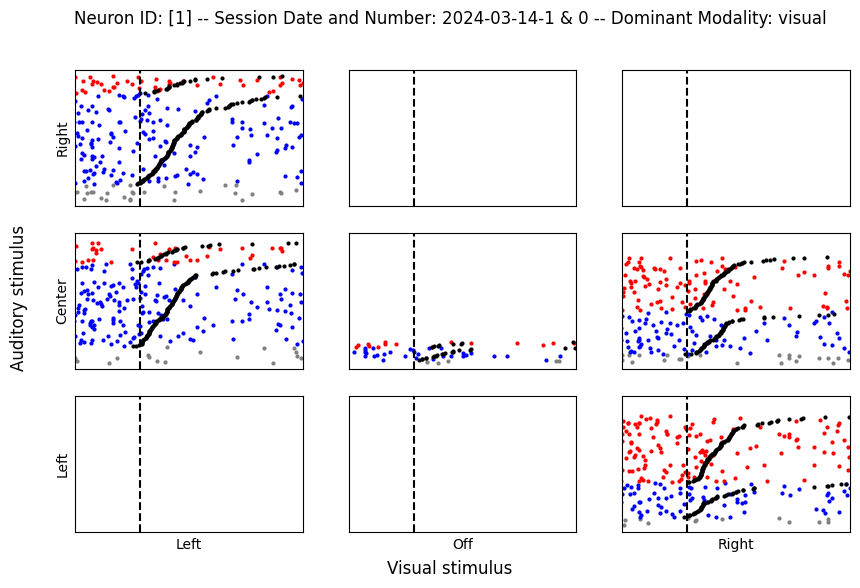

In [7]:
neuron_ids=1;first_move = True;sort_choice_loc = True;sort_response_time = True;xlim = (-0.2,0.5);figsize = (10,6)


masks = [{'aud_loc': 'r', 'vis_loc': 'l'},
        {'aud_loc': 'c', 'vis_loc': 'l'},
        {'aud_loc': 'l', 'vis_loc': 'l'},
        {'aud_loc': 'r', 'vis_loc': 'o'},
        {'aud_loc': 'c', 'vis_loc': 'o'},
        {'aud_loc': 'l', 'vis_loc': 'o'},
        {'aud_loc': 'r', 'vis_loc': 'r'},
        {'aud_loc': 'c', 'vis_loc': 'r'},
        {'aud_loc': 'l', 'vis_loc': 'r'}]

fig, axs = plt.subplots(3, 3, figsize=figsize, sharex=True, sharey=True)
colors = ['gray','blue', 'red']

for mask in masks:
    obj.return_mask(**mask)
    ax = axs[masks.index(mask) % 3,masks.index(mask) // 3,]
    if first_move:
        timeline = obj.trials.timeline_firstMoveOn - obj.trials.timeline_audPeriodOn
    else:
        timeline = obj.trials.timeline_choiceMoveOn - obj.trials.timeline_audPeriodOn
        
    if neuron_ids is None:
        neuron_ids = obj.formatted_data.keys()
    elif type(neuron_ids) is int:
        neuron_ids = [neuron_ids]

    if not sort_choice_loc and not sort_response_time:
        sorted_index = obj.mask_interest_indices
    else:
        df = pd.DataFrame({'response_direction': obj.trials.response_direction.to_numpy()[obj.mask_interest_indices],
                        'timeline': timeline.to_numpy()[obj.mask_interest_indices]})
        if sort_choice_loc and sort_response_time:
            df_sorted = df.sort_values(by=['response_direction', 'timeline'])
            sorted_index = df_sorted.index
        elif sort_choice_loc:
            df_sorted = df.sort_values(by=['response_direction'])
            sorted_index = df_sorted.index
        else:
            df_sorted = df.sort_values(by=['timeline'])
            sorted_index = df_sorted.index

    for neuron_id in neuron_ids:
        baseline_spikes = obj.formatted_data[neuron_id]['spikes']['baseline']
        stimulus_spikes = obj.formatted_data[neuron_id]['spikes']['stimulus']
        
        
        for i in range(len(sorted_index)):
            trial_num = sorted_index[i]
            x_baseline = np.array(baseline_spikes[trial_num])
            x_stimulus = np.array(stimulus_spikes[trial_num])
            ax.plot(x_baseline, np.repeat(i, len(x_baseline)),'o', ms =2, 
                    color=colors[int(obj.trials.response_direction.to_numpy()[obj.mask_interest_indices][trial_num])])
            ax.plot(x_stimulus, np.repeat(i, len(x_stimulus)),'o', ms =2, 
                    color=colors[int(obj.trials.response_direction.to_numpy()[obj.mask_interest_indices][trial_num])])
            
        ax.plot(timeline.to_numpy()[obj.mask_interest_indices][sorted_index], range(len(sorted_index)), 'ko', ms = 2)

    ax.axvline(0, color='k', linestyle='--', label="Stimulus Onset")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
# Add individual x and y labels for each subplot

x_labels = ['Left', 'Off', 'Right']
y_labels = ['Right', 'Center', 'Left']
for i in range(3):
    axs[2, i].set_xlabel(f'{x_labels[i]}')  # x labels for the bottom row
    axs[i, 0].set_ylabel(f'{y_labels[i]}')  # y labels for the left column

# Add major x and y labels for the entire figure, outside the plot
fig.text(0.5, 0.04, 'Visual stimulus', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Auditory stimulus', va='center', rotation='vertical', fontsize=12)
plt.suptitle(f'Neuron ID: {neuron_ids or "All"} -- Session Date and Number: {obj.session_date} & {obj.session_no} -- Dominant Modality: {obj.dominant_modality}')
# Adjust layout to make room for the labels
plt.tight_layout(rect=[1, 0, 1, 0.95])
# plt.tight_layout()
# plt.show()

### Per stimulus

## Significant firing rate change in respond to stimulus

### All stimuli - population

#### Apply significance test

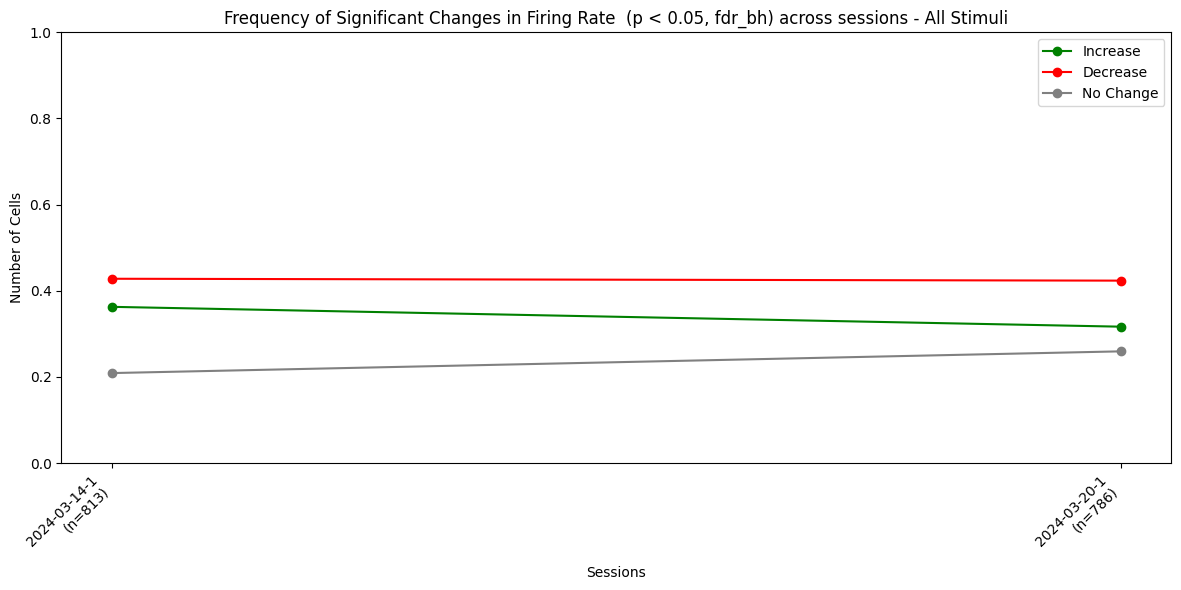

In [ ]:
parametric_test = True
one_sided = True
multiple_correction = True

mc_test = 'fdr_bh' # 'bonferroni', 'sidak', 'holm', 'fdr_bh'
mc_alpha = 0.05

data.test_firing_rate_change_stimulus_sessions(parametric_test = parametric_test,
                                               one_sided = one_sided,
                                               multiple_correction = multiple_correction,
                                               mc_test = mc_test, mc_alpha = mc_alpha)

### Per stimulus - population

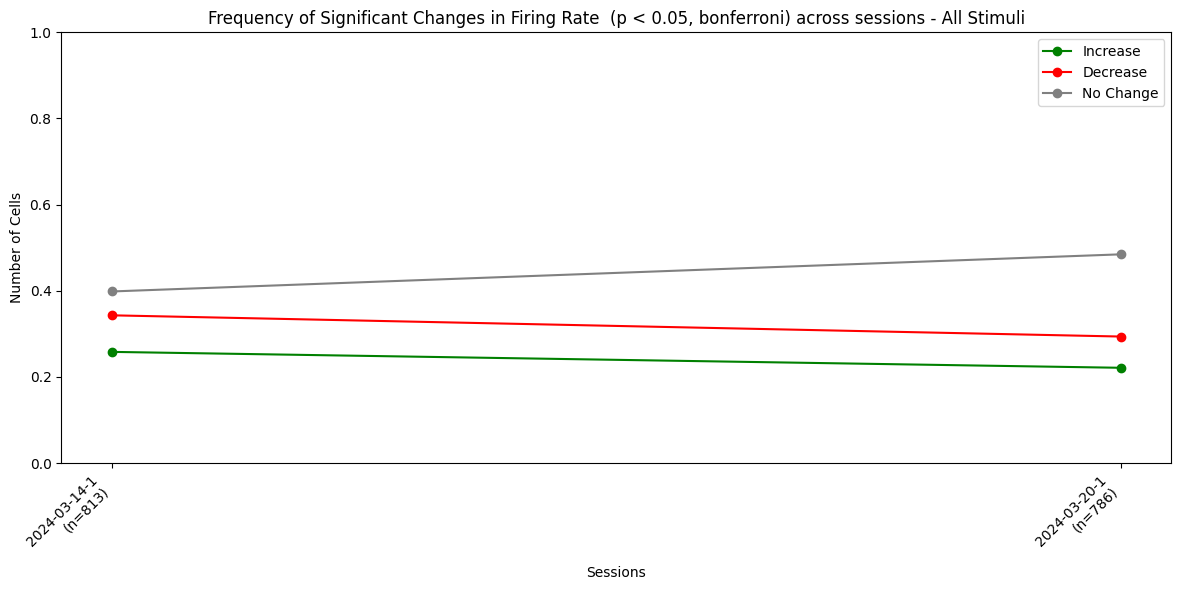

In [ ]:
# params

trial_type_list = ['visual', 'coherent', 'audio', 'conflict', 'all']
mask_info_list = []
mask_info_list.append({'stim_loc': 'left', 'modality': 'visual', 'choice_correct': 'no_choice', 'choice_loc': 'left', 'conflict_info': None})

parametric_test = True
one_sided = True
multiple_correction = True
mc_test = 'bonferroni' # 'bonferroni', 'sidak', 'holm', 'fdr_bh'
mc_alpha = 0.05

data.test_firing_rate_change_stimulus_sessions(parametric_test = parametric_test,
                                               one_sided = one_sided,
                                               multiple_correction = multiple_correction,
                                               mc_test = mc_test, mc_alpha = mc_alpha)


In [10]:
mask_results = []
for mask_info in mask_info_list:
    data.return_mask(**mask_info)
    data.test_firing_rate_change_stimulus_sessions(parametric_test = parametric_test,
                                                    one_sided = one_sided,
                                                    multiple_correction = multiple_correction,
                                                    mc_test = mc_test, mc_alpha = mc_alpha, plot = False)
    mask_results.append(data.test_firing_rate_change_stimulus_sessions_results)
    
    ### for each mask store the results: n_total, n_increase, n_decrease, n_no_change
    ### for each mask one subplot - barplot
    ### number of subplots = number of masks
    ### on x axis the sessions
    ### on y axis the frequencies
    ### number of bars = at one session = 3: increase, decrease, no change
    ### number of triplet bars = number of sessions

/var/folders/l1/l742y54d4hx05wj38054vs_r0000gn/T/ipykernel_17482/1459257262.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.session_dates,rotation=45, ha='right')


<Figure size 1200x600 with 0 Axes>

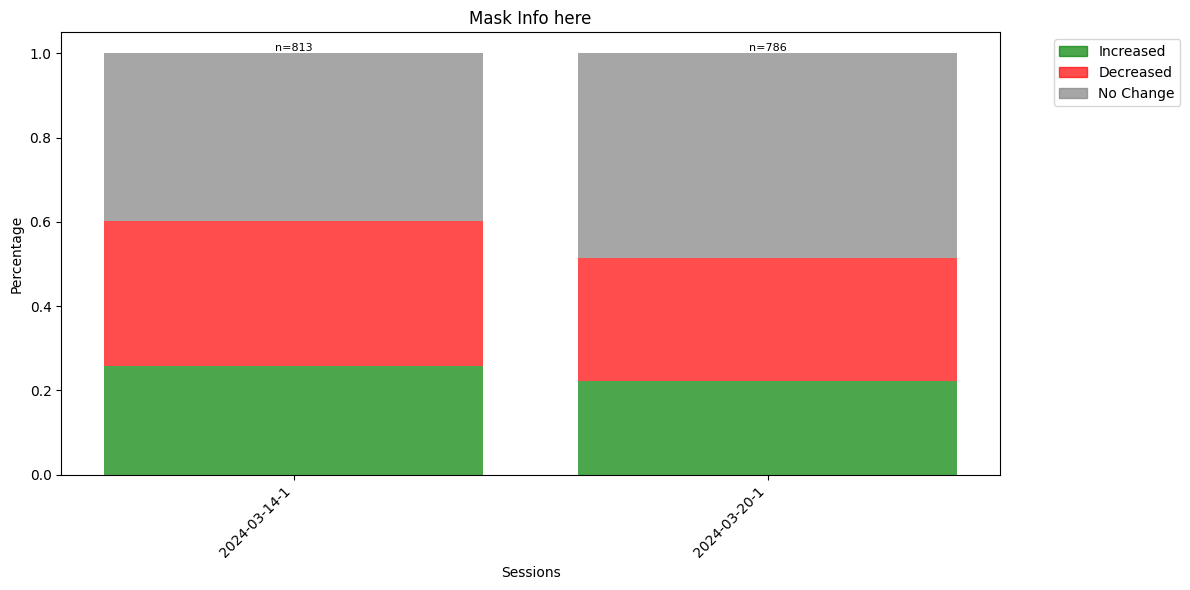

In [ ]:
plt.figure(figsize=(12, 6))

fig, axs = plt.subplots(len(mask_results), 1, figsize=(12, 6), sharex=True)
colours = ['green', 'red','gray']

 
for mask_no in range(len(mask_results)):
    if len(mask_results) == 1:
        ax = axs
    else:
        ax = axs[mask_no]
    ax.bar(data.session_dates, mask_results[mask_no]['freq_up_regulated'], label='Increased Activity', color = colours[0], alpha = 0.7)
    # plt.bar(data.session_dates, mask_results[mask_no]['freq_up_regulated'], label='Increased Activity', color = colours[0], alpha = 0.7)
    ax.bar(data.session_dates, mask_results[mask_no]['freq_down_regulated'], label='Decreased Activity', bottom=mask_results[mask_no]['freq_up_regulated'], color = colours[1], alpha = 0.7)
    ax.bar(data.session_dates, mask_results[mask_no]['freq_no_change'], label = 'No Change', bottom=np.array(mask_results[mask_no]['freq_up_regulated'])+np.array(mask_results[mask_no]['freq_down_regulated']), color = colours[2], alpha = 0.7)
    # ax.text()
    for i in range(len(mask_results[0]['n_total'])):
        ax.text(
                i,  # X-coordinate
                1,  # Y-coordinate, slightly above the top of the bar
                f"n={mask_results[mask_no]['n_total'][i]}",  # Text to display
                ha='center', va='bottom', fontsize=8  # Alignment and font size
            )
        
    # Labels and customization
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Percentage')
    ax.set_title('Mask Info here')
    ax.set_xticklabels(data.session_dates,rotation=45, ha='right')


    # Simplified legend with manual patches
    legend_patches = [
        Patch(color='green', alpha=0.7, label='Increased'),
        Patch(color='red', alpha=0.7, label='Decreased'),
        Patch(color='gray', alpha=0.7, label='No Change'),
    ]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

# TBD

In [12]:
# average firing rate across neurons

In [13]:
# dimension reduction - which neurons increase/decrease together 
# or at least find the ones that increase activity for a specific stimulus

# is it the case for all stimuli or only for some stimuli
# are there any specific neurons that are always increasing/decreasing together
# are there any specific stimuli that are always increasing/decreasing together


In [14]:
# firing rate variabili

In [15]:
# firing rate across different stimulus intensities
# correlation bw neuron firing rate changes and stimulus intensity

In [16]:
# Correlation Between Neurons

In [17]:
# Latency of Neuronal Response